In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [ ]:
# load the MNIST dataset

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.to_numpy().astype(np.float32)
y = mnist.target.astype(int).to_numpy()

In [27]:
# Normalize the data

X /= 255.0



In [30]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

X_train = X_train.reshape(-1,28, 28, 1)
X_test = X_test.reshape(-1,28, 28, 1)

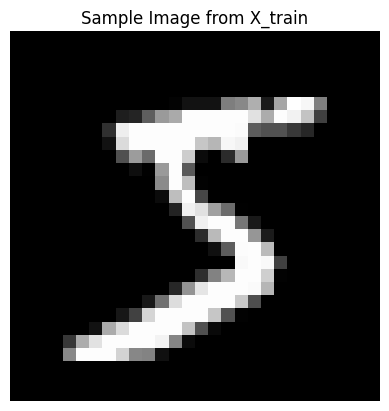

In [31]:

plt.imshow(X_train[0], cmap='gray')
plt.title("Sample Image from X_train")
plt.axis('off')
plt.show()


In [32]:
# general hyperparameters

n_epochs = 10
batch_size = 32
learning_rate = 0.001

# convolutional layer hyperparameters

n_filters = 8
filter_size = 3
stride = 1
padding = 0

# pooling layer hyperparameters

pool_size = 2

# fcl hyperparameters

fc1_output_size = 128
fc2_output_size = 10

print("Batch size:", batch_size)
print("Learning rate:", learning_rate)
print("Epochs:", n_epochs)
print("Conv1: {} filters, {}x{}, stride {}, padding {}".format(
    n_filters, filter_size, filter_size, stride, padding))
print("Pool size:", pool_size)
print("FC layer sizes:", fc1_output_size, "->", fc2_output_size)



Batch size: 32
Learning rate: 0.001
Epochs: 10
Conv1: 8 filters, 3x3, stride 1, padding 0
Pool size: 2
FC layer sizes: 128 -> 10


In [36]:
class ConvLayer:
    def __init__(self, n_filters, filter_size, stride, padding):
        
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.stride = stride
        self.pad = padding
        
        # initialize filters
        self.filters = np.random.randn(n_filters, filter_size, filter_size) / (filter_size * filter_size)
        self.biases = np.zeros((n_filters, 1))
        
        
    def forward(self, input):
        '''
        Performs a forward pass
        '''
        
        #cache input for the backward pass
        self.input = input
        batch, depth, height, width = input.shape
        
        output_width = (width - self.filter_size + 2 * self.pad) // self.stride + 1
        output_height = (height - self.filter_size + 2 * self.pad) // self.stride + 1
        
        output = np.zeros((batch, self.n_filters, output_height, output_width))
        
        for b in range(batch):
            
            for f in range(self.n_filters):
                
                for i in range(output_height):
                    
                    for j in range(output_width):
                        
                        region = input[b, :, i:i+self.filter_size, j:j+self.filter_size]
                        
                        output[b, f, i, j] = np.sum(region * self.filters[f]) + self.b[f]
                        
        
        return output
    
    def backward(self, dout, learning_rate):
        '''
        Performs a backward pass
        '''
        
        batch, depth, height, width = self.input.shape
        out_height = height - self.filter_size + 1
        out_width = width - self.filter_size + 1
        
        dfilters = np.zeros(self.filters.shape)
        dbiases = np.zeros(self.b.shape)
        dinput = np.zeros(self.input.shape)
        
        for b in range(batch):
            
            for f in range(self.num_filters):
                
                for i in range(out_height):
                    
                    for j in range(out_width):
                        
                        region = self.input[b, :, i:i+self.filter_size, j:j+self.filter_size]
                        dfilters[f] += dout[b, f, i, j] * region
                        dbiases[f] += dout[b, f, i, j]
                        dinput[b, :, i:i+self.filter_size, j:j+self.filter_size] += dout[b, f, i, j] * self.filters[f]
                        
        self.filters -= learning_rate * dfilters
        self.biases  -= learning_rate * dbiases
        
        return dinput
        

(1, 1, 28, 28)
Output shape: (1, 8, 26, 26)


In [ ]:
class MaxPoolLayer:
    
    def __init__(self, pool_size):
        self.pool_size = pool_size
        
    def forward(self, input):
        
        self.input = input
        batch, depth, height, width = input.shape
        out_height = height // self.pool_size
        out_width = width // self.pool_size
        
        output = np.zeros((batch, depth, out_height, out_width))
        self.argmax = np.zeros((batch, depth, out_height, out_width), dtype=int)
        
        for b in range(batch):
            
            for d in range(depth):
                
                for i in range(out_height):
                    
                    for j in range(out_width):
                        
                        region = input[b, d, i*self.pool_size:(i+1)*self.pool_size,
                                             j*self.pool_size:(j+1)*self.pool_size]
                        output[b, d, i, j] = np.max(region)
                        self.argmax[b, d, i, j] = np.argmax(region)
        
        return output
    
    def backward(self, dout):
        
        batch, depth, height, width = self.input.shape
        dinput = np.zeros_like(self.input)
        out_height = height // self.pool_size
        out_width  = width // self.pool_size
        
        for b in range(batch):
            for d in range(depth):
                for i in range(out_height):
                    for j in range(out_width):
                        region = self.input[b, d,
                                i*self.pool_size:(i+1)*self.pool_size,
                                j*self.pool_size:(j+1)*self.pool_size]
                        idx = self.argmax[b, d, i, j]
                        idx0 = idx // pool_size
                        idx1 = idx % pool_size 
                        dinput[b, d, i*self.pool_size + idx0, j*self.pool_size + idx1] = dout[b, d, i, j]
        
        return dinput            

In [ ]:
class FCLayer:

    def __init__(self, input_size, output_size):
        
        self.weights = np.random.randn(output_size, input_size) / input_size
        self.biases = np.zeros((output_size, 1))   
        
    def forward(self, input):
        
        self.input = input
        return np.dot(self.weights, input) + self.biases
    
    def backward(self, dout, learning_rate):
        
        dweights = np.dot(dout, self.input.T)
        dbiases = np.sum(dout, axis=1, keepdims=True)
        dinput = np.dot(self.weights.T, dout)
        
        self.weights -= learning_rate * dweights
        self.biases  -= learning_rate * dbiases
        
        return dinput

In [ ]:
class Activation